# House Price Prediction in King County Using Keras

This is a deep learning version of house price prediction using Keras deep learning package with Tensorflow backend. Dataset from Kaggle. Thanks to ironfrown who shared the code.

## Preparation

*Load standard Python libraries.*

In [1]:
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

*Load Keras libraries.*

In [2]:
import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model

Using TensorFlow backend.
/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load all data

*Load data from CSV file and define the label column.*

In [3]:
kc_data_org = pd.read_csv("./input/kc_house_data.csv")

*Transform dates into year, month and day and select columns.*

In [4]:
kc_data_org['sale_yr'] = pd.to_numeric(kc_data_org.date.str.slice(0, 4))
kc_data_org['sale_month'] = pd.to_numeric(kc_data_org.date.str.slice(4, 6))
kc_data_org['sale_day'] = pd.to_numeric(kc_data_org.date.str.slice(6, 8))

In [5]:
kc_data = pd.DataFrame(kc_data_org, columns=[
        'sale_yr','sale_month','sale_day',
        'bedrooms','bathrooms','sqft_living','sqft_lot','floors',
        'condition','grade','sqft_above','sqft_basement','yr_built',
        'zipcode','lat','long','sqft_living15','sqft_lot15','price'])
label_col = 'price'

print(kc_data.describe())

            sale_yr    sale_month      sale_day      bedrooms     bathrooms  \
count  21613.000000  21613.000000  21613.000000  21613.000000  21613.000000   
mean    2014.322954      6.574423     15.688197      3.370842      2.114757   
std        0.467616      3.115308      8.635063      0.930062      0.770163   
min     2014.000000      1.000000      1.000000      0.000000      0.000000   
25%     2014.000000      4.000000      8.000000      3.000000      1.750000   
50%     2014.000000      6.000000     16.000000      3.000000      2.250000   
75%     2015.000000      9.000000     23.000000      4.000000      2.500000   
max     2015.000000     12.000000     31.000000     33.000000      8.000000   

        sqft_living      sqft_lot        floors     condition         grade  \
count  21613.000000  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean    2079.899736  1.510697e+04      1.494309      3.409430      7.656873   
std      918.440897  4.142051e+04      0.539989    

## Split data for training and validation

*Function to split a range of data frame / array indeces into three sub-ranges.*

In [6]:
def train_validate_test_split(df, train_part=.6, validate_part=.2, test_part=.2, seed=None):
    np.random.seed(seed)
    total_size = train_part + validate_part + test_part
    train_percent = train_part / total_size
    validate_percent = validate_part / total_size
    test_percent = test_part / total_size
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = perm[:train_end]
    validate = perm[train_end:validate_end]
    test = perm[validate_end:]
    return train, validate, test

*Split index ranges into three parts, however, ignore the third.*

In [7]:
train_size, valid_size, test_size = (70, 30, 0)
kc_train, kc_valid, kc_test = train_validate_test_split(kc_data, 
                              train_part=train_size, 
                              validate_part=valid_size,
                              test_part=test_size,
                              seed=2017)

*Extract data for training and validation into x and y vectors.*

In [22]:
kc_y_train = kc_data.loc[kc_train, [label_col]]
kc_x_train = kc_data.loc[kc_train, :].drop(label_col, axis=1)
kc_y_valid = kc_data.loc[kc_valid, [label_col]]
kc_x_valid = kc_data.loc[kc_valid, :].drop(label_col, axis=1)

print('Size of training set: ', len(kc_x_train))
print('Size of training labels: ', len(kc_y_train))
print('Size of validation set: ', len(kc_x_valid))
print('Size of test set: ', len(kc_test), '(not converted)')

Size of training set:  15129
Size of training labels:  15129
Size of validation set:  6483
Size of test set:  1 (not converted)


## Prepare data for training and validation of the Keras model

*Function to get statistics about a data frame.*

In [9]:
def norm_stats(df1, df2):
    dfs = df1.append(df2)
    minimum = np.min(dfs)
    maximum = np.max(dfs)
    mu = np.mean(dfs)
    sigma = np.std(dfs)
    return (minimum, maximum, mu, sigma)

*Function to Z-normalise the entire data frame - note stats for Z transform passed in.*

In [10]:
def z_score(col, stats):
    m, M, mu, s = stats
    df = pd.DataFrame()
    for c in col.columns:
        df[c] = (col[c]-mu[c])/s[c]
    return df

*Normalise training and validation predictors using the stats from training data only (to ensure the same transformation applies to both training and validation data), and then convert them into numpy arrays to be used by Keras.*

In [25]:
stats = norm_stats(kc_x_train, kc_x_valid)
arr_x_train = np.array(z_score(kc_x_train, stats))
arr_y_train = np.array(kc_y_train)
arr_x_valid = np.array(z_score(kc_x_valid, stats))
arr_y_valid = np.array(kc_y_valid)

print('Training shape:', arr_x_train.shape)
print('Training samples: ', arr_x_train.shape[0])
print('passing values:: ' , arr_x_train.shape[1], arr_y_train.shape[1])
print('Validation samples: ', arr_x_valid.shape[0])

Training shape: (15129, 18)
Training samples:  15129
passing values::  18 1
Validation samples:  6483


## Create Keras model

***Three functions to define alternative Keras models***

*simple three layers and Adam optimizer.*

In [36]:
def basic_model_1(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dense(50, activation="relu", kernel_initializer='normal'))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=['accuracy'])
    return(t_model)

*4 layers with Adam optimizer and 10% dropouts.*

In [45]:
def basic_model_2(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(20, activation="relu"))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=['accuracy'])
    return(t_model)

*Slightly complex, extends the previous model with Nadam optimizer, dropouts and L1/L2 regularisers.*

In [46]:
def basic_model_3(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer='nadam',
        metrics=['accuracy'])
    return(t_model)

*Define how many epochs of training should be done and what is the batch size.*

In [15]:
epochs = 500
batch_size = 128

print('Epochs: ', epochs)
print('Batch size: ', batch_size)

Epochs:  500
Batch size:  128


*Specify Keras callbacks which allow additional functionality while the model is being fitted.*
- ***ModelCheckpoint*** *allows to save the models as they are being built or improved.*
- ***TensorBoard*** *interacts with TensorFlow interactive reporting system.*
- ***EarlyStopping*** *watches one of the model measurements and stops fitting when no improvement.*

In [40]:
keras_callbacks = [
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=2)
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}.hdf5', monitor='val_loss', save_best_only=True, verbose=0)
    # TensorBoard(log_dir='/tmp/keras_logs/model_3', histogram_freq=1, write_graph=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None),
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)
]

In [34]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='./tmp/keras_logs', histogram_freq=1,write_graph=True)

*Fit the model and record the history of training and validation.*<br/>
*As we specified EarlyStopping with patience=20, with luck the training will stop in less than 200 epochs.*

*Now we create the model - use one of the above functions.*

## Fit/Train Keras model

In [37]:
model_1 = basic_model_1(arr_x_train.shape[1], arr_y_train.shape[1])
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 100)               1900      
_________________________________________________________________
dense_15 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 51        
Total params: 7,001
Trainable params: 7,001
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 100)               1900      
_________________________________________________________________
dense_15 (Dense)             (None, 50)                5050      
_________________________________________________________________
den

In [44]:
history_1 = model_1.fit(arr_x_train, arr_y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=2, # Change it to 2, if wished to observe execution
    validation_data=(arr_x_valid, arr_y_valid))

Train on 15129 samples, validate on 6483 samples
Epoch 1/500
0s - loss: 418792469608.7081 - acc: 0.0000e+00 - val_loss: 440989889092.6299 - val_acc: 0.0000e+00
Epoch 2/500
0s - loss: 418191055108.5856 - acc: 0.0000e+00 - val_loss: 440295656873.6794 - val_acc: 0.0000e+00
Epoch 3/500
0s - loss: 417451205590.7802 - acc: 0.0000e+00 - val_loss: 439463515879.1621 - val_acc: 0.0000e+00
Epoch 4/500
0s - loss: 416583816484.6005 - acc: 0.0000e+00 - val_loss: 438504024491.4169 - val_acc: 0.0000e+00
Epoch 5/500
0s - loss: 415578064792.9841 - acc: 0.0000e+00 - val_loss: 437386103194.9900 - val_acc: 0.0000e+00
Epoch 6/500
0s - loss: 414427489201.9597 - acc: 0.0000e+00 - val_loss: 436131048763.7452 - val_acc: 0.0000e+00
Epoch 7/500
0s - loss: 413140518531.7480 - acc: 0.0000e+00 - val_loss: 434735877434.4816 - val_acc: 0.0000e+00
Epoch 8/500
0s - loss: 411717329845.2085 - acc: 0.0000e+00 - val_loss: 433193079259.7502 - val_acc: 0.0000e+00
Epoch 9/500
0s - loss: 410166603497.9518 - acc: 0.0000e+00 - va

#### With Model 2

In [47]:
model_2 = basic_model_2(arr_x_train.shape[1], arr_y_train.shape[1])
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 100)               1900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_19 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 21        
Total params: 7,991
Trainable params: 7,991
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
den

In [48]:
history_2 = model_2.fit(arr_x_train, arr_y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=2, # Change it to 2, if wished to observe execution
    validation_data=(arr_x_valid, arr_y_valid))

Train on 15129 samples, validate on 6483 samples
Epoch 1/500
0s - loss: 419690701164.4138 - acc: 0.0000e+00 - val_loss: 442050334558.8894 - val_acc: 0.0000e+00
Epoch 2/500
0s - loss: 418705858471.7393 - acc: 0.0000e+00 - val_loss: 439675556550.7820 - val_acc: 0.0000e+00
Epoch 3/500
0s - loss: 414168655733.7881 - acc: 0.0000e+00 - val_loss: 432165279334.2736 - val_acc: 0.0000e+00
Epoch 4/500
0s - loss: 403562892352.2327 - acc: 0.0000e+00 - val_loss: 417449459780.2351 - val_acc: 0.0000e+00
Epoch 5/500
0s - loss: 385396643223.3935 - acc: 0.0000e+00 - val_loss: 394480396167.0090 - val_acc: 0.0000e+00
Epoch 6/500
0s - loss: 359268518109.8701 - acc: 0.0000e+00 - val_loss: 363515452966.1453 - val_acc: 0.0000e+00
Epoch 7/500
0s - loss: 326067061713.9068 - acc: 0.0000e+00 - val_loss: 326153642005.4814 - val_acc: 0.0000e+00
Epoch 8/500
0s - loss: 288004060766.1154 - acc: 0.0000e+00 - val_loss: 285152804616.3320 - val_acc: 0.0000e+00
Epoch 9/500
0s - loss: 248137199276.2234 - acc: 0.0000e+00 - va

#### With Model 3

In [49]:
model_3 = basic_model_3(arr_x_train.shape[1], arr_y_train.shape[1])
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 80)                1520      
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 120)               9720      
_________________________________________________________________
dropout_3 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 20)                2420      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)                210       
__________

In [50]:
history_3 = model_3.fit(arr_x_train, arr_y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=2, # Change it to 2, if wished to observe execution
    validation_data=(arr_x_valid, arr_y_valid))

Train on 15129 samples, validate on 6483 samples
Epoch 1/500
0s - loss: 407817466565.6051 - acc: 0.0000e+00 - val_loss: 377658208161.8608 - val_acc: 0.0000e+00
Epoch 2/500
0s - loss: 215426580693.3418 - acc: 0.0000e+00 - val_loss: 126037314792.3468 - val_acc: 0.0000e+00
Epoch 3/500
0s - loss: 117002481547.7179 - acc: 0.0000e+00 - val_loss: 119223133867.1405 - val_acc: 0.0000e+00
Epoch 4/500
0s - loss: 113037292622.1757 - acc: 0.0000e+00 - val_loss: 115939349261.5443 - val_acc: 0.0000e+00
Epoch 5/500
0s - loss: 109927861776.8196 - acc: 0.0000e+00 - val_loss: 112325252639.5113 - val_acc: 1.5425e-04
Epoch 6/500
0s - loss: 106108117316.3445 - acc: 0.0000e+00 - val_loss: 107621949613.1149 - val_acc: 0.0000e+00
Epoch 7/500
0s - loss: 101044416200.3802 - acc: 0.0000e+00 - val_loss: 102483032772.5707 - val_acc: 0.0000e+00
Epoch 8/500
0s - loss: 95417381306.9279 - acc: 0.0000e+00 - val_loss: 97196786101.2099 - val_acc: 0.0000e+00
Epoch 9/500
0s - loss: 89092732979.0342 - acc: 0.0000e+00 - val_l

## Evaluate and report performance of the trained model

In [18]:
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE:  69928.9177 , Train Loss:  14133538137.9
Val MAE:  78698.3085 , Val Loss:  22450837718.8


*This function allows plotting of the training history*

In [19]:
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

*Now plot the training history, i.e. the Mean Absolute Error and Loss (Mean Squared Error), which were both defined at the time of model compilation. Note that the plot shows validation error as less than training error, which is quite deceptive. The reason for this is that training error is calculated for the entire epoch (and at its begining it was much worse than at the end), whereas the validation error is taken from the last batch (after the model improved). See the above evaluation statistics to confirm that the evaluation puts these errors in the correct order at the very end.*

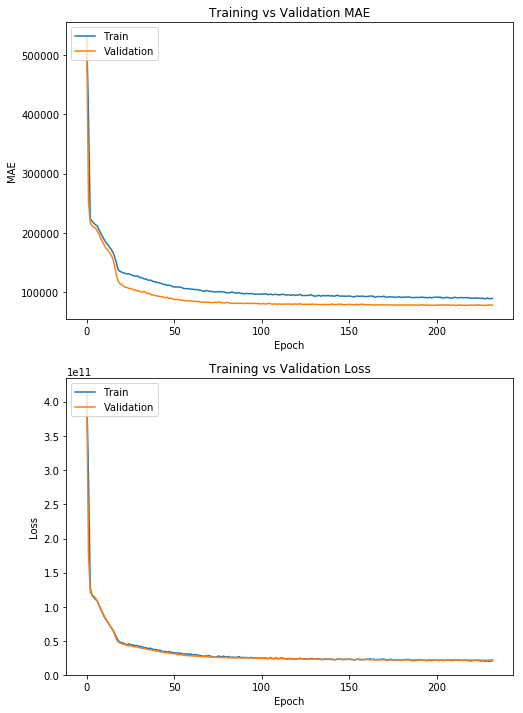

In [20]:
plot_hist(history.history, xsize=8, ysize=12)

In [54]:
x=1e9
count = 0
while count < 1000001:
    x += 0.000001
    count += 1
print('before subtract:: ', x)
x = x - 1e9
print(x)

before subtract::  1000000000.9536753
0.9536752700805664
